<a href="https://colab.research.google.com/github/cshah1995/Deep-Learning-CIFAR10-Data/blob/main/CIFAR10_image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the libraries

In [1]:
import os
import tarfile
import torch as t
import matplotlib
import numpy as np
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

%matplotlib inline


#Downloading the dataset

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

* Let's extract the dataset

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')


##Reading the data

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
train_class = os.listdir(data_dir + '/train')
print(train_class)
test_class = os.listdir(data_dir + '/test')
print(test_class)

['test', 'train']
['dog', 'bird', 'frog', 'airplane', 'horse', 'ship', 'automobile', 'truck', 'cat', 'deer']
['dog', 'bird', 'frog', 'airplane', 'horse', 'ship', 'automobile', 'truck', 'cat', 'deer']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0545.png', '0323.png', '1961.png', '4542.png', '1861.png']


In [6]:
data = ImageFolder(data_dir + '/train' , transform= ToTensor())

In [7]:
print(data.class_to_idx)
print(data.classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


##Visualize the images

* We now demonstrata and check a few images

In [8]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

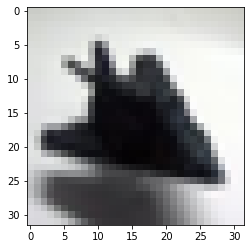

In [9]:
img,lbl = data[0]
img.shape
perm_img = img.permute(1,2,0)
plt.imshow(perm_img)

* We build a helper function to view images

In [10]:
def view_image(image,label):
  fig, ax = plt.subplots(figsize=(8, 6))
  plt.imshow(image.permute(1,2,0))
  print('The label is:', data.classes[label])
  print('The index is:', "("+str(label)+")") 

The label is: bird
The index is: (2)


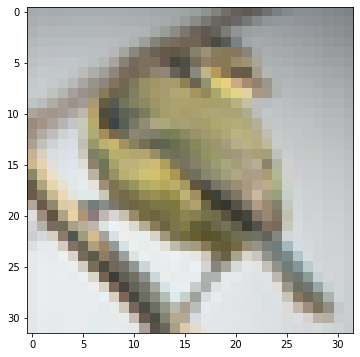

In [11]:
view_image(*data[11299])

The label is: airplane
The index is: (0)
The label is: automobile
The index is: (1)
The label is: bird
The index is: (2)


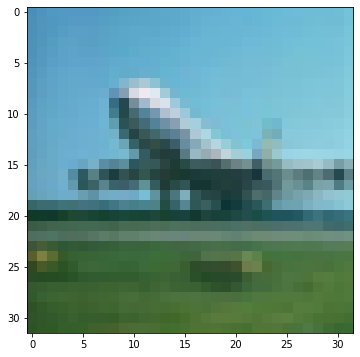

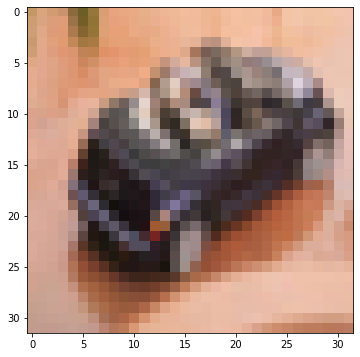

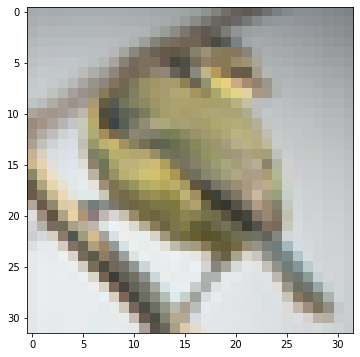

In [12]:
x = [100, 5499, 11299]
img = [view_image(*data[i]) for i in x]


#Splitting the data

In [13]:
random_seed = 42
t.manual_seed(random_seed);

In [14]:
DVAL_SIZE = 5000 #@param {type : 'slider', min : 2500, max: 20000, step : 2500}
DTR_SIZE = len(data) - DVAL_SIZE

dtr,dval = random_split(data, [DTR_SIZE, DVAL_SIZE])
len(dtr), len(dval)


(45000, 5000)

##Creating batches of data

In [15]:
BATCH_SIZE = 128 #@param {type: 'slider', min:64, max : 256, step: 64}

In [16]:
dtr_dl = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
dval_dl = DataLoader(data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

In [17]:
for img, lbl in dtr_dl:
  print(img.shape)
  print(lbl.shape)
  break

torch.Size([128, 3, 32, 32])
torch.Size([128])


##Visualising grid of images

In [18]:
def show_batch_images(batch):
  for image,label in batch:
    fig,ax= plt.subplots(figsize = (16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(image, nrow=16 ).permute(1,2,0))
    break

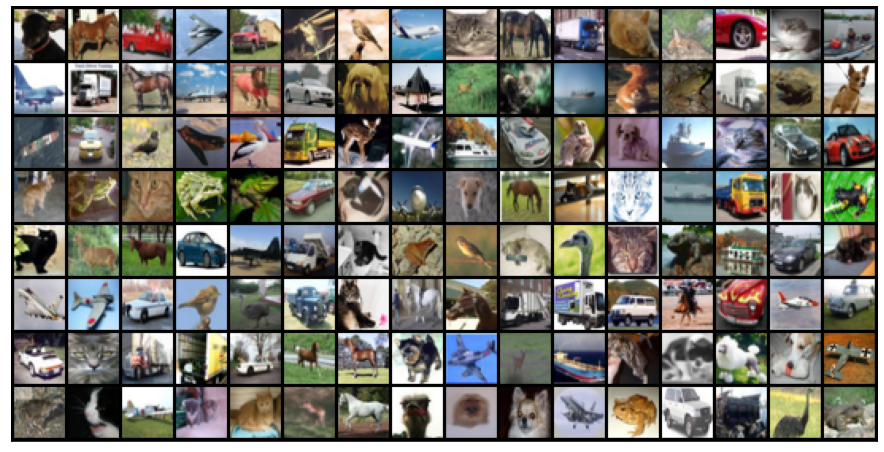

In [19]:
show_batch_images(dtr_dl)

#Data Modelling

##Implementation of a simple CNN

In [21]:
simple_model = nn.Sequential(
    nn.Conv2d(in_channels= 3,out_channels= 8,kernel_size= 3, stride= 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [24]:
for img, lbl in dtr_dl:
  print('Input image shape is:', img.shape)
  output = simple_model(img)
  print('Output image shape is:', output.shape)
  break

Input image shape is: torch.Size([128, 3, 32, 32])
Output image shape is: torch.Size([128, 8, 16, 16])


##Implementing actual CNN model

In [36]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = t.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = t.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = t.max(outputs, dim=1)
    return t.tensor(t.sum(preds == labels).item() / len(preds))

In [37]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [30]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [38]:
for images, labels in dtr_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0350, -0.0019, -0.0219,  0.0068, -0.0297,  0.0514,  0.0325,  0.0130,
        -0.0191, -0.0075], grad_fn=<SelectBackward0>)


##Defining functions to move data to the GPU/CPU device

In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if t.cuda.is_available():
        return t.device('cuda')
    else:
        return t.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
device

device(type='cuda')

##Moving the batches of data and model to GPU

In [42]:
dtr_devdl = DeviceDataLoader(dtr_dl, device)
dval_devdl = DeviceDataLoader(dval_dl, device)
to_device(model, device);


In [53]:
@t.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=t.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = t.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
model = to_device(Cifar10CnnModel(), device)

In [55]:
evaluate(model, dval_devdl)

{'val_acc': 0.09964923560619354, 'val_loss': 2.3029167652130127}

In [56]:
num_epochs = 10
opt_func = t.optim.Adam
lr = 0.001

#Training the images

In [57]:
history = fit(num_epochs, lr, model, dtr_devdl, dval_devdl, opt_func)

Epoch [0], train_loss: 1.7347, val_loss: 1.3528, val_acc: 0.4995
Epoch [1], train_loss: 1.1994, val_loss: 1.0463, val_acc: 0.6218
Epoch [2], train_loss: 0.9273, val_loss: 0.8262, val_acc: 0.7067
Epoch [3], train_loss: 0.7527, val_loss: 0.6386, val_acc: 0.7760
Epoch [4], train_loss: 0.6082, val_loss: 0.4716, val_acc: 0.8414
Epoch [5], train_loss: 0.4895, val_loss: 0.3545, val_acc: 0.8824
Epoch [6], train_loss: 0.3875, val_loss: 0.2615, val_acc: 0.9100
Epoch [7], train_loss: 0.2934, val_loss: 0.1975, val_acc: 0.9328
Epoch [8], train_loss: 0.2102, val_loss: 0.1603, val_acc: 0.9479
Epoch [9], train_loss: 0.1584, val_loss: 0.1295, val_acc: 0.9565


#Plotting the acccuracy and losses

In [58]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

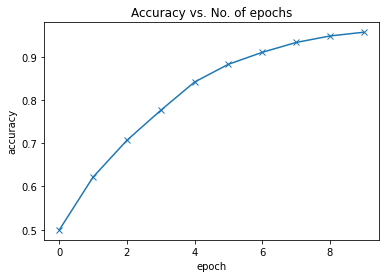

In [59]:
plot_accuracies(history)

In [60]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    

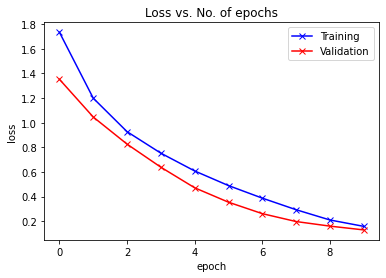

In [61]:
plot_losses(history)

#Testing the trained model

In [62]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [73]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = t.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


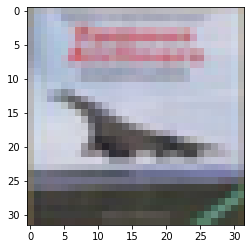

In [74]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


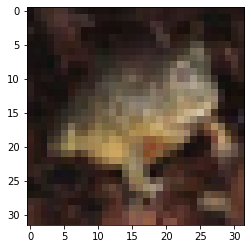

In [75]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [83]:
dtest_devdl = DeviceDataLoader(DataLoader(test_dataset, BATCH_SIZE*2), device)
result = evaluate(model, dtest_devdl)
result

{'val_acc': 0.7646484375, 'val_loss': 0.952874481678009}

#Saving the trained model

In [84]:
t.save(model.state_dict(), 'cifar10-cnn.pth')
saved_model = to_device(Cifar10CnnModel(), device)
saved_model.load_state_dict(t.load('cifar10-cnn.pth'))
evaluate(saved_model, dtest_devdl)

{'val_acc': 0.7646484375, 'val_loss': 0.952874481678009}